# Experiment #2 - Derived Features

## Overview

The purpose of this experiment is to determine whether derived features improve model performance. As part of the feature engineering process, we added the following categorical features:

* `pcontacted_last_campaign` - whether the customer was previously contacted as part of a campaign
* `pcampaign` - whether the customer was part of the the previous campaign
* `previous` - the original `previous` attribute converted to a discrete value
* `campaign_gte10` - whether the customer was contacted 10 or more times as part of this campaign

In [232]:
%load_ext autoreload
%autoreload 2

from utils import code

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
import pandas as pd
import numpy as np
import scikitplot as skplt

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import mutual_info_classif, chi2

# Model evaluation
from sklearn.model_selection import train_test_split
from support.evaluation import plot_learning_curve, evaluate_model

# Support
from support.model import Model, build_tuned_model
from support.datasets import get_data
from support.experiments import experiment_1, experiment_2, get_scorer
from support import parameters as params

# Algos
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline

## Data

In [234]:
X, y = get_data('../data/train.csv')
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,25,blue-collar,single,high.school,no,yes,no,cellular,jul,mon,619,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
1,40,admin.,married,high.school,no,no,no,telephone,jun,thu,97,1,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1
2,51,technician,married,university.degree,no,yes,no,cellular,aug,wed,512,5,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
3,37,blue-collar,married,high.school,unknown,yes,no,cellular,jul,tue,423,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
4,54,housemaid,married,university.degree,unknown,yes,no,cellular,aug,thu,297,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1


Create a validation set and train the model then score on the test set. The performance will be biased since we are using less training data.

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=1)

## ML Models

In [236]:
scorer = get_scorer()

Apply feature computations

In [242]:
pipeline_1 = experiment_1.get_pipeline()
features = pipeline_1.fit_transform(X)
ps = features.shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 32,950, Features: 61


### Original Model

Make sure we still get the same results ~.67 AUC

In [245]:
# Naive Bayes
param_grid = [{
  'nb__alpha': [0, 0.01, 0.1, 1],
  'nb__fit_prior': [True, False]
}]

tuned_model = build_tuned_model('nb', BernoulliNB(), X_train, y_train, param_grid, scorer, pipeline=pipeline_1, cv_folds=5)

==> Starting 5-fold cross validation for nb model, 26360 examples
==> Elapsed seconds: 3.567
Best nb model: BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=False)
Best nb score: 0.711


### New Model

How does the performance change with the new features?

In [243]:
pipeline_2 = experiment_2.get_pipeline()
features = pipeline_2.fit_transform(X)
ps = features.shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 32,950, Features: 67


In [246]:
tuned_model = build_tuned_model('nb', BernoulliNB(), X_train, y_train, param_grid, scorer, pipeline=pipeline_2, cv_folds=5)

==> Starting 5-fold cross validation for nb model, 26360 examples
==> Elapsed seconds: 4.290
Best nb model: BernoulliNB(alpha=0, binarize=0.0, class_prior=None, fit_prior=False)
Best nb score: 0.658


/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [247]:
n_targeted_test = int(params.P_TARGETED * len(X_test))
revenue = params.AVG_REVENUE
cost = params.AVG_COST

probs = tuned_model.model.predict_proba(tuned_model.pipeline.transform(X_test))
preds = tuned_model.model.predict(tuned_model.pipeline.transform(X_test))

# Create a dataframe of probabilities and actual / predicted outcomes
probs_df = pd.DataFrame(np.hstack([probs, y_test.values.reshape(-1,1), preds.reshape(-1,1)]), columns=['p_no', 'p_yes', 'actual', 'predicted'])

# Sort customers by the probability that they will convert
model_targets = probs_df.sort_values('p_yes', ascending=False)

# Take the top 6.6%
model_targets = model_targets.head(n_targeted_test)

# Calculate financial outcomes
model_outcomes = model_targets.actual.apply(lambda x: cost if x == 0 else cost + revenue)

In [248]:
print(classification_report(model_targets.actual, model_targets.predicted))
print('Expected profit: ${:,}'.format(sum(model_outcomes)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       228
         1.0       0.47      1.00      0.64       206

   micro avg       0.47      0.47      0.47       434
   macro avg       0.24      0.50      0.32       434
weighted avg       0.23      0.47      0.31       434

Expected profit: $219,626


/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The score is lower than the original model, is it a high bias or high variance problem?

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


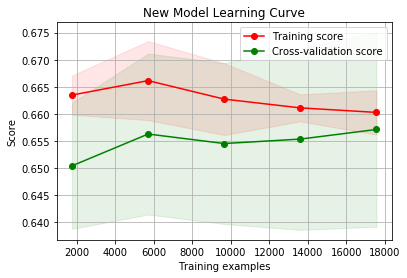

In [151]:
plot_learning_curve(tuned_model.model, 'New Model Learning Curve', experiment_2.get_pipeline().fit_transform(X_train), y_train, scoring=scorer);

High bias, and slightly higher variance. Can we improve it with feature selection?

### Feature Selection

In [5]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,25,blue-collar,single,high.school,no,yes,no,cellular,jul,mon,619,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
1,40,admin.,married,high.school,no,no,no,telephone,jun,thu,97,1,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1
2,51,technician,married,university.degree,no,yes,no,cellular,aug,wed,512,5,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
3,37,blue-collar,married,high.school,unknown,yes,no,cellular,jul,tue,423,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
4,54,housemaid,married,university.degree,unknown,yes,no,cellular,aug,thu,297,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1


In [112]:
# Create a copy of the data frame with categorical features only
cat_ct = experiment_2.get_categorical_ct()
X_fs = cat_ct.fit_transform(X_train)
features = experiment_2.CATEGORICAL_FEATURES + experiment_2.NEW_CATEGORICAL_FEATURES
X_fs_df = pd.DataFrame(X_fs, columns=features)

In [221]:
ohe_features = experiment_2.get_categorical_pipeline().fit_transform(X_train, y_train)
print('Number of features:', ohe_features.shape[1])

Number of features: 66


In [211]:
param_grid = [{
  'nb_fs__alpha': [0, 0.01, 0.1, 1],
  'nb_fs__fit_prior': [True, False],
  'kbest__k': np.arange(1, ohe_features.shape[1]+1),
  'kbest__score_func': [chi2, mutual_info_classif]
}]

ft_pipeline = Pipeline([
  ('cat', experiment_2.get_categorical_pipeline()),
  ('kbest', SelectKBest())
])

tuned_model = build_tuned_model('nb_fs', BernoulliNB(), X_train, y_train, param_grid, scorer, pipeline=ft_pipeline, cv_folds=3)

==> Starting 3-fold cross validation for nb_fs model, 26360 examples
==> Elapsed seconds: 351.680
Best nb_fs model: BernoulliNB(alpha=0, binarize=0.0, class_prior=None, fit_prior=False)
Best nb_fs score: 0.658


/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [212]:
tuned_model.pipeline.steps[-1]

('kbest', SelectKBest(k=18, score_func=<function chi2 at 0x1a15f76950>))

The model achieves maximum performance with 18/66 features. At this point, we could consider adding numeric features and evaluating the performance of more powerful models if stakeholders are not satisfied with a \$56,316 lift over the baseline heuristic-based model and are willing to incur additional costs to improve the model.